# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (229/229), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6295 (from 2)
Receiving objects: 100% (6559/6559), 116.26 MiB | 19.38 MiB/s, done.
Resolving deltas: 100% (275/275), done.


In [ ]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

from torch.utils.data import DataLoader, random_split
from torchvision import transforms as T, datasets, models
import torch.optim as optim
from torchsummary import summary
from torchvision.models import resnet18, ResNet18_Weights

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

**FIXING THE SEED**

In [ ]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda


**DATA AUGMENTATION AND NORMALIZATION**

To improve the performances of our models, we first preprocessed the data. The preprocessing is divided into two main steps.

*   Normalization: we normalize the data, computing the mean and standard deviation of the training set, since it is considered to be a good practice for improving the training process, as discussed in forums such as https://discuss.pytorch.org/t/understanding-transform-normalize/21730. We normalize both the training and validation datasets with the statistics of the training set for consistency.

* Data augmentation: we define a series of different transformations for data augmentation of the training set, collecting ideas from different sources (e.g., https://toxigon.com/pytorch-data-augmentation-techniques) and consulting the official PyTorch documentation about transformations to enrich the training data, helping our model to learn more general patterns.

We also explored the distribution of the different classes in the training and validation sets to gather insights about the data that can be used for a better tuning of the hyperparameters of our models.

In [ ]:
def plot_data(dataset, name):
    """ Show the distribution of classes in the dataset

    Args:
      dataset: the dataset to plot
    """

    labels, counts = np.unique(dataset.labels, return_counts=True)
    plt.bar(labels, counts)
    plt.title(f"Histogram of {name} classes")
    plt.xlabel('Class ID')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
def custom__mean_std(dataset):
    """ Compute the mean and standard deviation of the dataset

    Args:
      dataset: the dataset to compute the mean and standard deviation

    Returns:
      mean: the mean of the dataset
      std: the standard deviation of the dataset
    """
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for image, _ in dataset:
        mean += image.sum(dim=[1,2])
    mean = mean / (len(dataset)*224*224)
    for image, _ in dataset:
        std += ((image - mean.view(3,1,1))**2).sum(dim=[1,2])
    std = (std / (len(dataset)*224*224))**0.5
    return mean, std

In [ ]:
""" Definition of transformation pipelines for data augmentation of training dataset and for the validation"""

train_transform = T.Compose([
    T.ToTensor()
])

train = GroceryStoreDataset('train', train_transform)

mean, std = custom__mean_std(train)

train_transform_norm = T.Compose([
    T.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    T.RandomRotation(degrees=5),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomAffine(degrees=0, shear=5, scale=(0.9, 1.1)),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    T.ToTensor(),
    T.Normalize(mean, std)
])

val_transform_norm = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean, std)
])

train_dataset = GroceryStoreDataset('train', train_transform_norm)
val_dataset = GroceryStoreDataset('val', val_transform_norm)

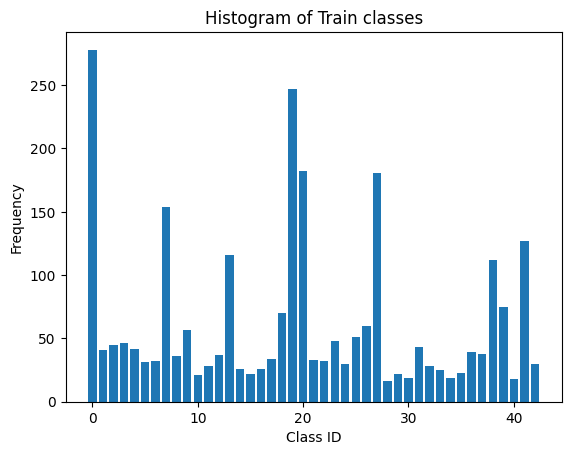

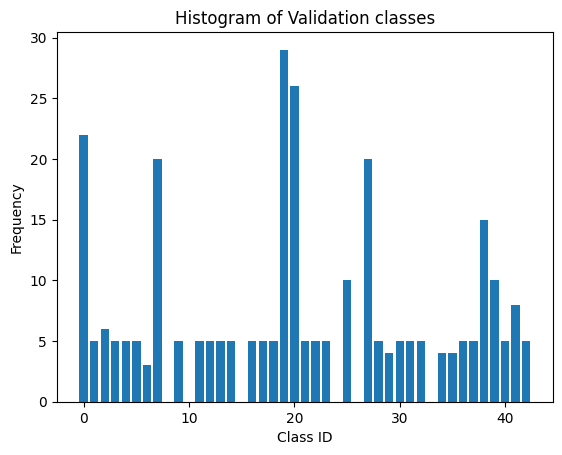

In [ ]:
plot_data(train_dataset, "Train")
plot_data(val_dataset, "Validation")

We can see that the distributions between the training and validation sets are quite similar, indicating that the training set is a good representation of real-world instances. However, some issues may still arise during training due to class imbalances.

**Building the models**

First we define some useful function for training.

In [ ]:
def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop(model, train_dl, epochs, opt, sched, patience, val_dl=None, verbose=True):
    """ Define the train loop for the models, updating weights at each gradient computation and keeping
    track of the best set of weights found so far. It also implement early stopping, to stop the training process
    after too much epoches without improvements in validation metrics.

    Args:
        model: model to train
        train_dl: training data
        epochs: number of epochs
        opt: optimizer to perform updates
        sched: learning rate scheduler
        patience: maximum number of epochs without improvement in validation before stopping training
        val_dl: validation data
        verbose: if True, print the training progress

    Returns:
        best_val_acc = best validation accuracy found
        best_params = best set of weights found
        best_epoch = epoch at which the best set of weights was found
        train_losses = list of training losses
        val_losses = list of validation losses
        train_accs = list of training accuracies
        val_accs = list of validation accuracies
    """

    best_val_acc = 0
    best_params = []
    best_epoch = -1
    curr_patience = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for e in tqdm(range(epochs)):
        if curr_patience == patience:
          break
        model.train()
        # Train
        train_loss = 0
        train_samples = 0
        train_acc = 0
        for train_data in train_dl:
            imgs = train_data[0].to(device)
            labels = train_data[1].to(device)
            scores = model(imgs)
            loss = F.cross_entropy(scores, labels)
            train_loss += loss.item() * imgs.shape[0]
            train_samples += imgs.shape[0]
            train_acc += ncorrect(scores, labels).item()

            opt.zero_grad()  # clear
            loss.backward()  # fill
            opt.step()       # use

        train_acc /= train_samples
        train_loss /= train_samples
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_samples = 0
            val_acc = 0
            if val_dl is not None:
                for val_data in val_dl:
                    imgs = val_data[0].to(device)
                    labels = val_data[1].to(device)
                    val_scores = model(imgs)
                    val_loss += F.cross_entropy(val_scores, labels).item() * imgs.shape[0]
                    val_samples += imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()
                val_acc /= val_samples
                val_loss /= val_samples
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                if sched is not None:
                    sched.step(val_loss)

            if val_dl is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_dl is not None else 0
                best_params = model.state_dict()
                torch.save(best_params, "best_model.pth")
                best_epoch = e
                curr_patience = 0
            else:
                curr_patience += 1


        if verbose and e%5 == 0:
            print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if val_dl is None else f" - valid loss {val_loss:.3f} - valid acc {val_acc:.3f}"))

    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc}")

    return best_val_acc, best_params, best_epoch, train_losses, val_losses, train_accs, val_accs

In [ ]:
def plot_training(train_losses, val_losses, train_accs, val_accs):
    """ Plot the training and validation losses and accuracies

    Args:
      train_losses: list of training losses
      val_losses: list of validation losses
      train_accs: list of training accuracies
      val_accs: list of validation accuracies
      """
    plt.figure(figsize=(15, 7))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()


    plt.figure(figsize=(15, 7))
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.grid(True)
    plt.legend()

    plt.show()

**BASELINE MODEL**

For the definition of our models, we followed the concepts described by the VGG architecture (https://medium.com/@ilaslanduzgun/create-vgg-from-scratch-in-pytorch-aa194c269b55).

For our first model, we define a very simple CNN with three convolutional blocks working as feature extractors and a final classification head. Each convolutional block is composed of a convolutional layer (kernel size of 3 and stride and padding of 1) followed by a ReLU activation layer to add non-linearity and a max pooling layer for dimensionality reduction. The last pooling layer before the classifier is an adaptive average pooling layer to reduce the number of parameters of the classifier.

In [ ]:
class Baseline(nn.Module):
    def __init__(self, num_classes=43):
        super(Baseline, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.layers = [self.layer1, self.layer2, self.layer3]
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256, out_features=num_classes)
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.fc(x)
        return x

In [ ]:
baseline = Baseline()
baseline.to(device)
summary(baseline, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
 AdaptiveAvgPool2d-9            [-1, 256, 1, 1]               0
          Flatten-10                  [-1, 256]               0
           Linear-11                   [-1, 43]          11,051
Total params: 381,867
Trainable params: 381,867
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/

**Hyperparameters**

For this model (but also for the next two models of part 1), we used the following hyperparameters:

* Batch size of 64 to improve the regularization effects with respect to higher batch sizes, preventing overfitting towards majority classes without causing too much oscillation in the loss function, as it was happening with lower batch sizes.

*  AdamW with weight decay as the optimizer with an initial learning rate of 3e-4 to better achieve regularization effects on training.

* A learning rate scheduler to reduce the learning rate by a factor of 0.5 when the validation loss stops improving to dynamically adjust the learning rate during training.

In [ ]:
epochs = 100
batch_size = 64

optimizer = optim.AdamW(baseline.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_dataset,
    batch_size=batch_size
)


In [ ]:
best_val_acc, best_params, best_epoch, train_losses, val_losses, train_accs, val_accs = train_loop(
    baseline,
    train_dl,
    epochs,
    optimizer,
    scheduler,
    15,
    val_dl,
    verbose=True
)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: train loss 3.503 - train acc 0.108 - valid loss 3.452 - valid acc 0.101
Epoch 5: train loss 2.579 - train acc 0.248 - valid loss 2.775 - valid acc 0.247
Epoch 10: train loss 2.248 - train acc 0.323 - valid loss 2.600 - valid acc 0.287
Epoch 15: train loss 2.005 - train acc 0.392 - valid loss 2.395 - valid acc 0.324
Epoch 20: train loss 1.858 - train acc 0.422 - valid loss 2.355 - valid acc 0.345
Epoch 25: train loss 1.702 - train acc 0.447 - valid loss 2.274 - valid acc 0.361
Epoch 30: train loss 1.609 - train acc 0.486 - valid loss 2.190 - valid acc 0.358
Epoch 35: train loss 1.592 - train acc 0.498 - valid loss 2.252 - valid acc 0.358
Epoch 40: train loss 1.603 - train acc 0.484 - valid loss 2.238 - valid acc 0.338
Best epoch 27, best acc 0.36486486486486486


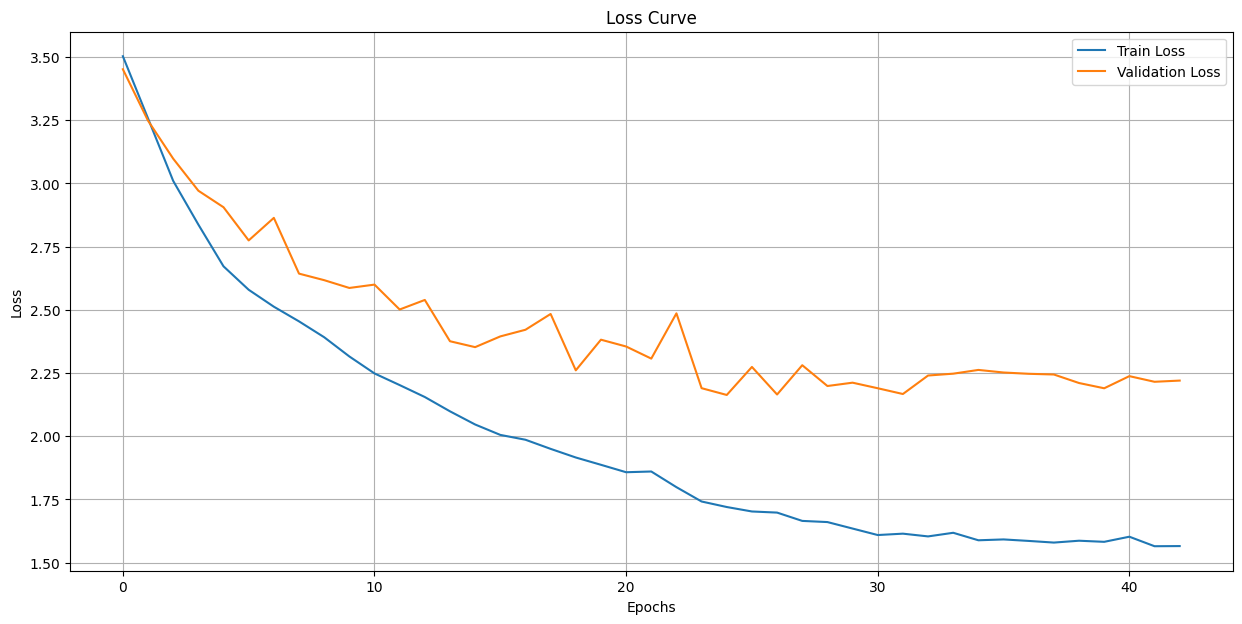

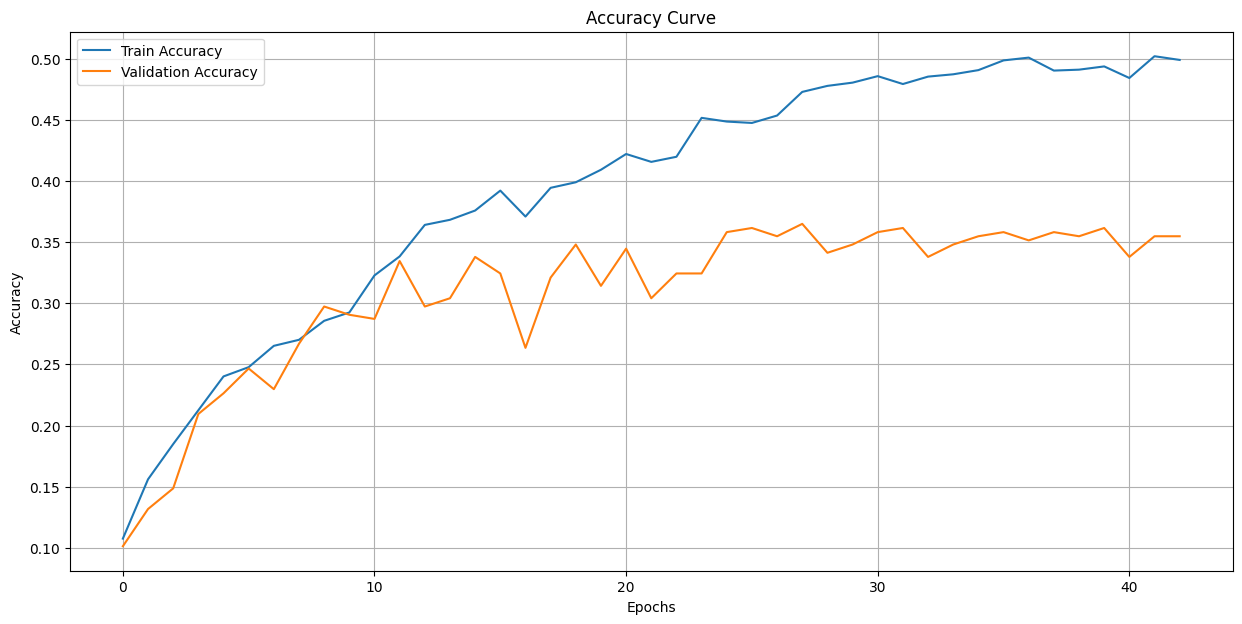

In [ ]:
plot_training(train_losses, val_losses, train_accs, val_accs)

From the training plots we can see that the model is not complex enough to reach a good validation accuracy.

**BATCH NORMALIZATION MODEL**

Our second model has almost the same number of parameters as the baseline, since it only adds a Batch Normalization layer after each Convolutional Layer, as it is in the real VGG architecture. With this model we wanted to experiment with the benefits of batch normalization without any other tweak in the network architecture.

In [ ]:
class BatchNormModel(nn.Module):
    def __init__(self, num_classes=43):
        super(BatchNormModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.layers = [self.layer1, self.layer2, self.layer3]
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256, out_features=num_classes)
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.fc(x)
        return x

In [ ]:
norm_model = BatchNormModel()
norm_model.to(device)
summary(norm_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
      BatchNorm2d-10          [-1, 256, 56, 56]             512
             ReLU-11          [-1, 256, 56, 56]               0
AdaptiveAvgPool2d-12            [-1, 256, 1, 1]               0
          Flatten-13                  [-1, 256]               0
           Linear-14                   

In [ ]:
epochs = 100
batch_size = 64

optimizer = optim.AdamW(norm_model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, val_losses, train_accs, val_accs = train_loop(
    norm_model,
    train_dl,
    epochs,
    optimizer,
    scheduler,
    15,
    val_dl,
    verbose=True
)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: train loss 3.062 - train acc 0.237 - valid loss 3.069 - valid acc 0.206
Epoch 5: train loss 1.970 - train acc 0.462 - valid loss 2.267 - valid acc 0.375
Epoch 10: train loss 1.565 - train acc 0.549 - valid loss 1.982 - valid acc 0.449
Epoch 15: train loss 1.321 - train acc 0.622 - valid loss 1.741 - valid acc 0.480
Epoch 20: train loss 1.118 - train acc 0.689 - valid loss 1.846 - valid acc 0.409
Epoch 25: train loss 0.969 - train acc 0.738 - valid loss 1.591 - valid acc 0.527
Epoch 30: train loss 0.888 - train acc 0.774 - valid loss 1.618 - valid acc 0.483
Epoch 35: train loss 0.814 - train acc 0.802 - valid loss 1.420 - valid acc 0.547
Epoch 40: train loss 0.791 - train acc 0.809 - valid loss 1.437 - valid acc 0.551
Epoch 45: train loss 0.768 - train acc 0.821 - valid loss 1.465 - valid acc 0.554
Best epoch 34, best acc 0.5608108108108109


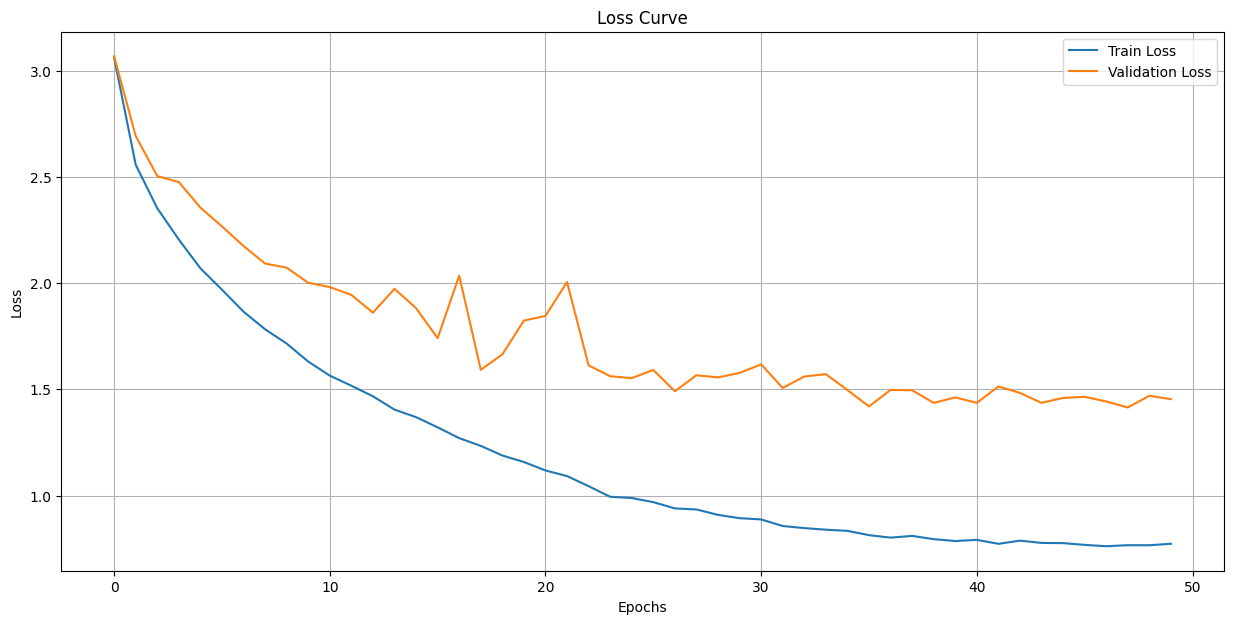

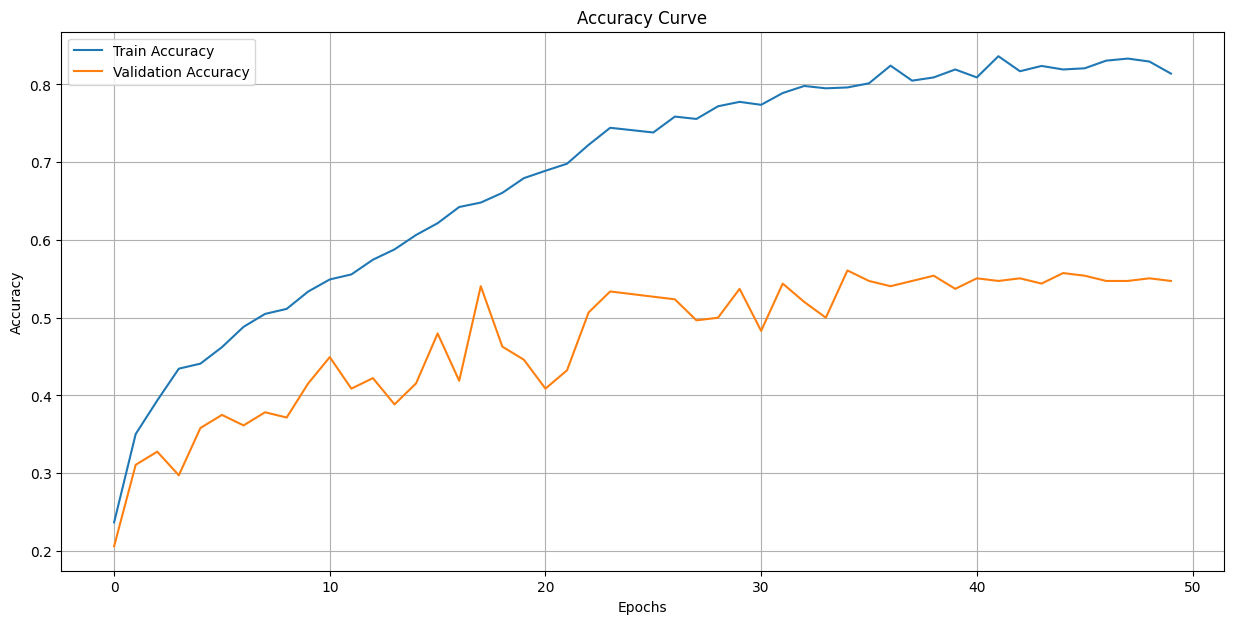

In [ ]:
plot_training(train_losses, val_losses, train_accs, val_accs)

We can see that just by adding batch normalization we highly increased the performances of the model, almost reaching the target validation accuracy.

**VGG MODEL**

Our last model increases the number of convolutional layers (followed by normalization and activation layers) before downsampling with max pooling. As in the actual VGG architectures, deeper convolutional blocks stack more convolutional layers, with the structure:

* Conv-Conv-Pooling

* Conv-Conv-Pooling

* Conv-Conv-Conv-Pooling

Since this last model has a more complex structure and we were worried about overfitting, we introduced a dropout layer with p=0.2 in the classifier head.



In [ ]:
class VGGModel(nn.Module):
    def __init__(self, num_classes=43):
        super(VGGModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.layers = [self.layer1, self.layer2, self.layer3]
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=256, out_features=num_classes)
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.fc(x)
        return x

In [ ]:
vgg = VGGModel()
vgg.to(device)
summary(vgg, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
epochs = 100
batch_size = 64

optimizer = optim.AdamW(vgg.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, val_losses, train_accs, val_accs = train_loop(
    vgg,
    train_dl,
    epochs,
    optimizer,
    scheduler,
    15,
    val_dl,
    verbose=True
)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: train loss 2.808 - train acc 0.305 - valid loss 2.863 - valid acc 0.206
Epoch 5: train loss 1.673 - train acc 0.527 - valid loss 2.212 - valid acc 0.331
Epoch 10: train loss 1.181 - train acc 0.669 - valid loss 1.565 - valid acc 0.497
Epoch 15: train loss 0.895 - train acc 0.769 - valid loss 1.382 - valid acc 0.574
Epoch 20: train loss 0.724 - train acc 0.808 - valid loss 1.280 - valid acc 0.655
Epoch 25: train loss 0.451 - train acc 0.906 - valid loss 1.096 - valid acc 0.649
Epoch 30: train loss 0.362 - train acc 0.931 - valid loss 1.116 - valid acc 0.696
Epoch 35: train loss 0.281 - train acc 0.964 - valid loss 1.024 - valid acc 0.723
Epoch 40: train loss 0.248 - train acc 0.968 - valid loss 1.033 - valid acc 0.713
Epoch 45: train loss 0.243 - train acc 0.970 - valid loss 1.034 - valid acc 0.716
Epoch 50: train loss 0.231 - train acc 0.971 - valid loss 1.014 - valid acc 0.723
Epoch 55: train loss 0.221 - train acc 0.975 - valid loss 1.006 - valid acc 0.713
Epoch 60: train lo

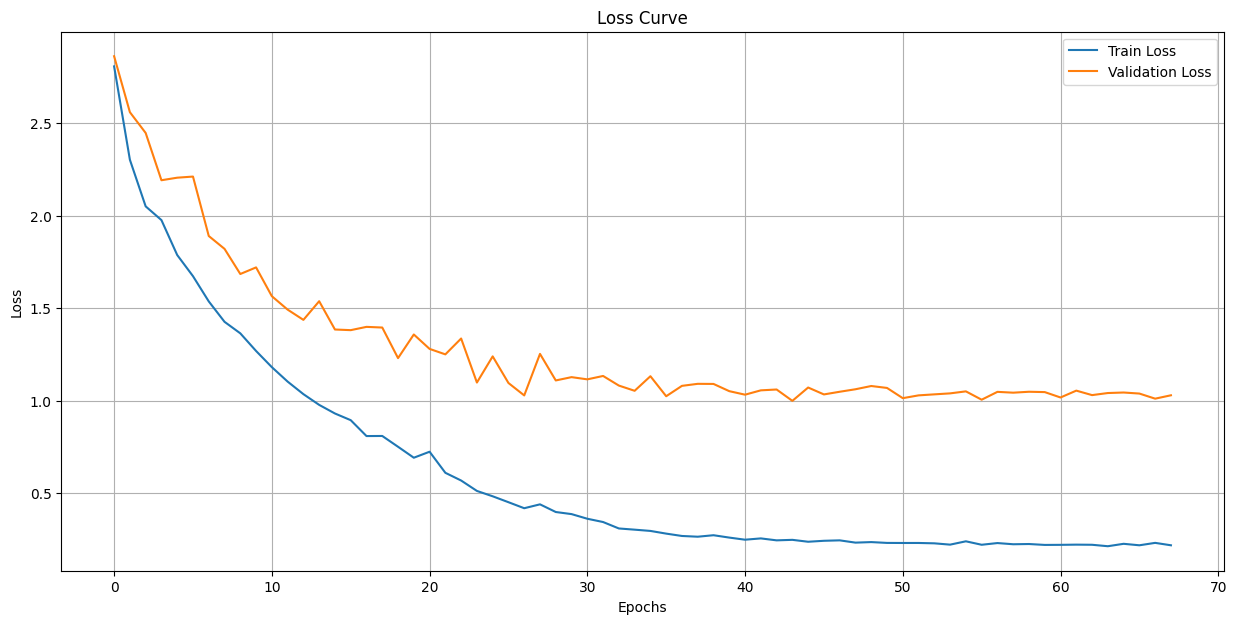

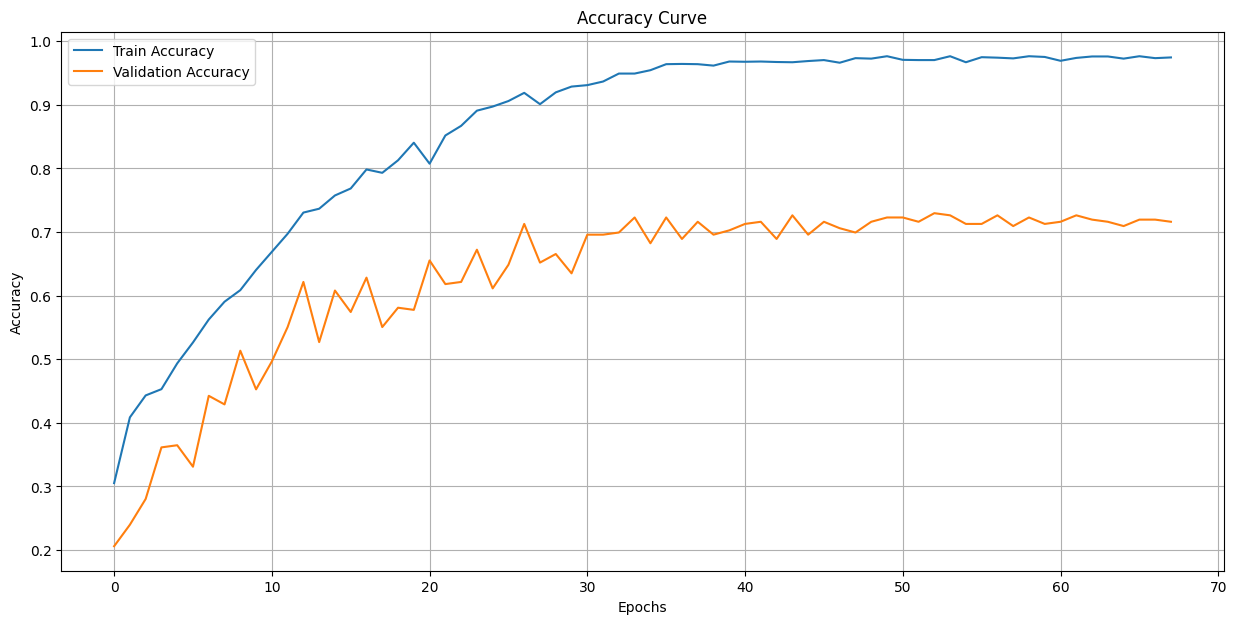

In [ ]:
plot_training(train_losses, val_losses, train_accs, val_accs)

With this final model we were able to surpass the target validation accuracy of 0.60

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

**FINE-TUNING THE NETWORK**

Our approach to fine-tuning ResNet was inspired by https://medium.com/we-talk-data/guide-to-freezing-layers-in-pytorch-best-practices-and-practical-examples-8e644e7a9598.

Our idea was to freeze the first layers of the model, which are the basic feature extractors, while unfreezing the deeper layer (where more complex patterns are extracted) and replacing the classifier head to retrain it from scratch.

In [ ]:
def set_requires_grad(layer: torch.nn.Module, train: bool) -> None:
    """Sets the requires_grad attribute to True or False for each parameter within a layer.

        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train


In [ ]:
res_net = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


In [ ]:
"""We substitue the classifier head (also adding the same dropout as the final model in part 1) and freeze most of the previous layers"""

res_net.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=res_net.fc.in_features, out_features=43)
)
res_net = res_net.to(device)
set_requires_grad(res_net.conv1, False)
set_requires_grad(res_net.bn1, False)
set_requires_grad(res_net.layer1, False)
set_requires_grad(res_net.layer2, False)
set_requires_grad(res_net.layer3, False)

summary(res_net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
"We fine-tuned the model with the same hyperparameters of part 1"

epochs = 100
batch_size = 64

optimizer = optim.AdamW(res_net.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, val_losses, train_accs, val_accs = train_loop(
    res_net,
    train_dl,
    epochs,
    optimizer,
    scheduler,
    15,
    val_dl,
    verbose=True
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: train loss 1.463 - train acc 0.633 - valid loss 0.982 - valid acc 0.747
Epoch 5: train loss 0.042 - train acc 0.993 - valid loss 0.559 - valid acc 0.838
Epoch 10: train loss 0.007 - train acc 1.000 - valid loss 0.664 - valid acc 0.834
Epoch 15: train loss 0.004 - train acc 1.000 - valid loss 0.619 - valid acc 0.814
Epoch 20: train loss 0.003 - train acc 1.000 - valid loss 0.619 - valid acc 0.818
Best epoch 5, best acc 0.8378378378378378


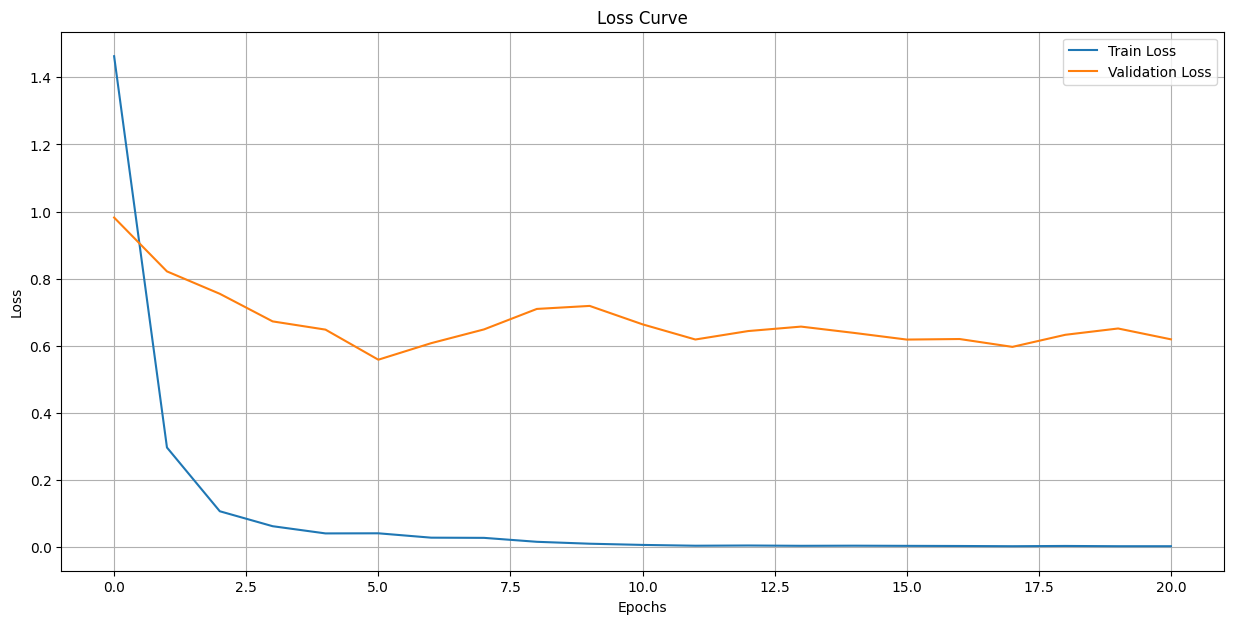

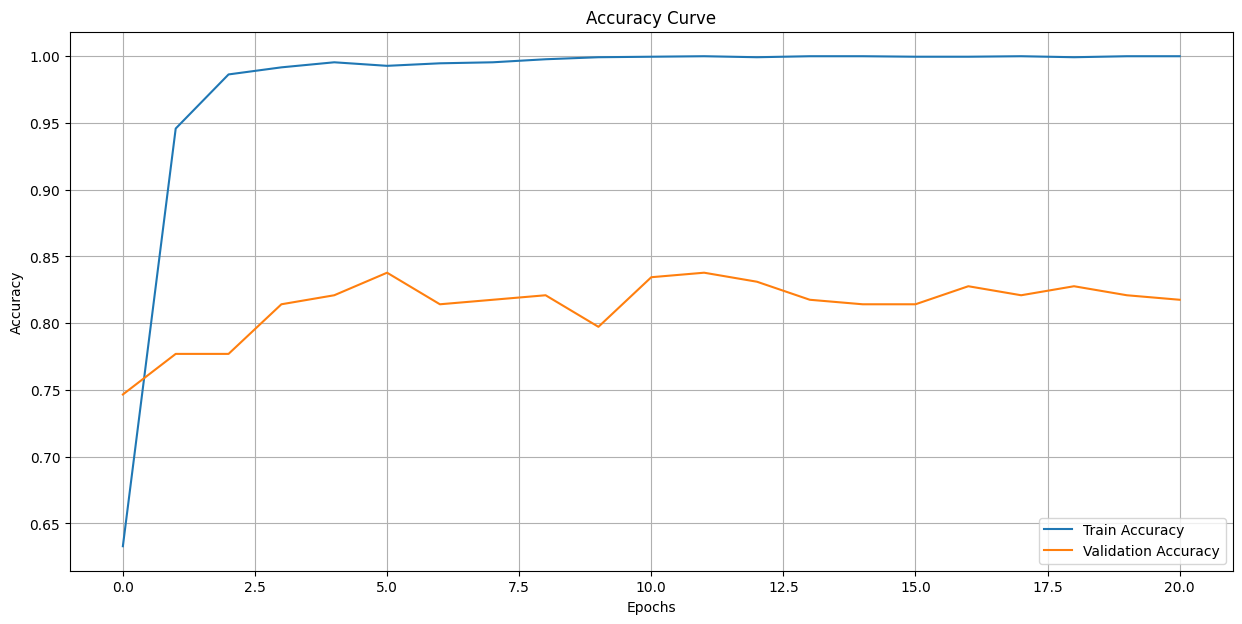

In [ ]:
plot_training(train_losses, val_losses, train_accs, val_accs)

Even if the model has reached the target validation accuracy, we can clearly see that it is overfitting, reaching very high values of training accuracy in the first epochs and finding the best validation accuracy just at epoch 5. For this reason we modified the hyperparameters to address this problem and achieve a smoother training process:

* Batch size reduced from 64 to 32, introducing more noise

* Initial learning rate reduced to 5e-5 and weight decay increased to 5e-4

* Dropout percentage in the classifier head increased to p=0.5.

We also normalize the training and validation datasets with the mean and standard deviation of ImageNet, which was the dataset on which the model was pre-trained, as it is considered the best practice when fine-tuning pre-trained models (https://markaicode.com/image-dataset-normalization-in-pytorch/).

In [ ]:
res_net = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

In [ ]:
res_net.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=res_net.fc.in_features, out_features=43)
)
res_net = res_net.to(device)
set_requires_grad(res_net.conv1, False)
set_requires_grad(res_net.bn1, False)
set_requires_grad(res_net.layer1, False)
set_requires_grad(res_net.layer2, False)
set_requires_grad(res_net.layer3, False)

summary(res_net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
train_transform_norm_imagenet = T.Compose([
    T.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    T.RandomRotation(degrees=5),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomAffine(degrees=0, shear=5, scale=(0.9, 1.1)),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform_norm_imagenet = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = GroceryStoreDataset('train', train_transform_norm_imagenet)
val_dataset = GroceryStoreDataset('val', val_transform_norm_imagenet)

In [ ]:
train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_dataset,
    batch_size=batch_size
)

In [ ]:
epochs = 100
batch_size = 32

optimizer = optim.AdamW(res_net.parameters(), lr=5e-5, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_dataset,
    batch_size=batch_size
)

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, val_losses, train_accs, val_accs = train_loop(
    res_net,
    train_dl,
    epochs,
    optimizer,
    None,
    15,
    val_dl,
    verbose=True
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: train loss 2.837 - train acc 0.298 - valid loss 2.148 - valid acc 0.436
Epoch 5: train loss 0.351 - train acc 0.944 - valid loss 0.864 - valid acc 0.794
Epoch 10: train loss 0.110 - train acc 0.991 - valid loss 0.634 - valid acc 0.824
Epoch 15: train loss 0.057 - train acc 0.995 - valid loss 0.605 - valid acc 0.838
Epoch 20: train loss 0.030 - train acc 0.998 - valid loss 0.520 - valid acc 0.855
Epoch 25: train loss 0.024 - train acc 0.998 - valid loss 0.542 - valid acc 0.841
Epoch 30: train loss 0.019 - train acc 0.998 - valid loss 0.582 - valid acc 0.848
Epoch 35: train loss 0.010 - train acc 1.000 - valid loss 0.516 - valid acc 0.831
Epoch 40: train loss 0.007 - train acc 1.000 - valid loss 0.521 - valid acc 0.855
Epoch 45: train loss 0.006 - train acc 1.000 - valid loss 0.558 - valid acc 0.834
Epoch 50: train loss 0.006 - train acc 1.000 - valid loss 0.454 - valid acc 0.865
Epoch 55: train loss 0.010 - train acc 0.998 - valid loss 0.476 - valid acc 0.851
Epoch 60: train lo

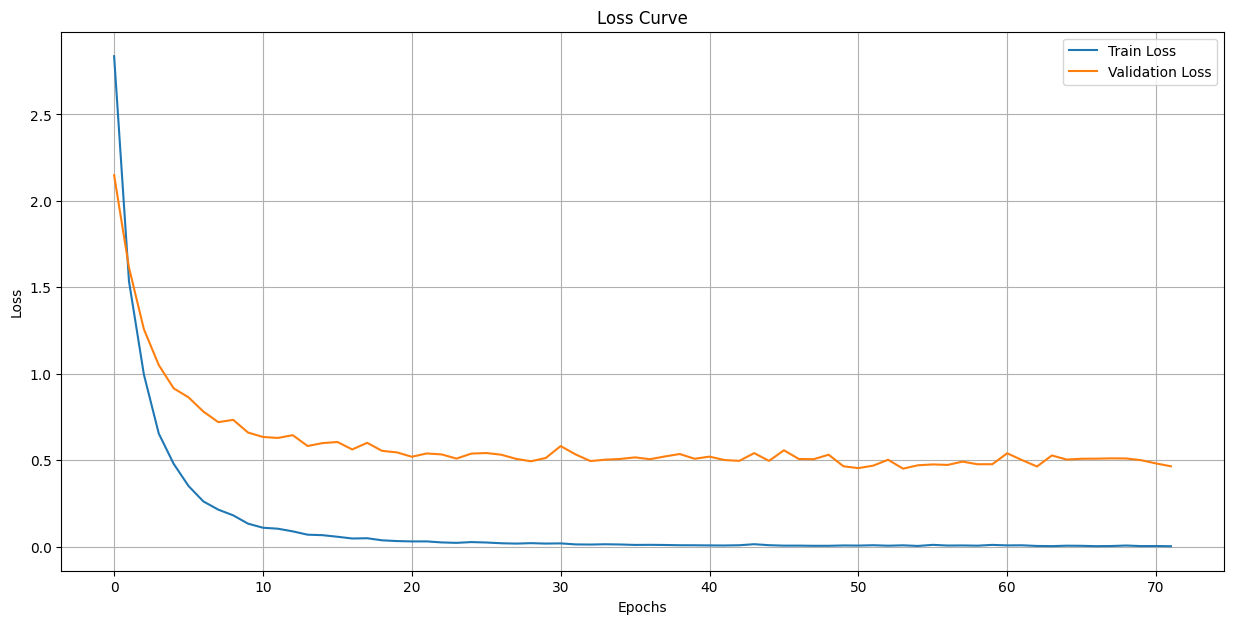

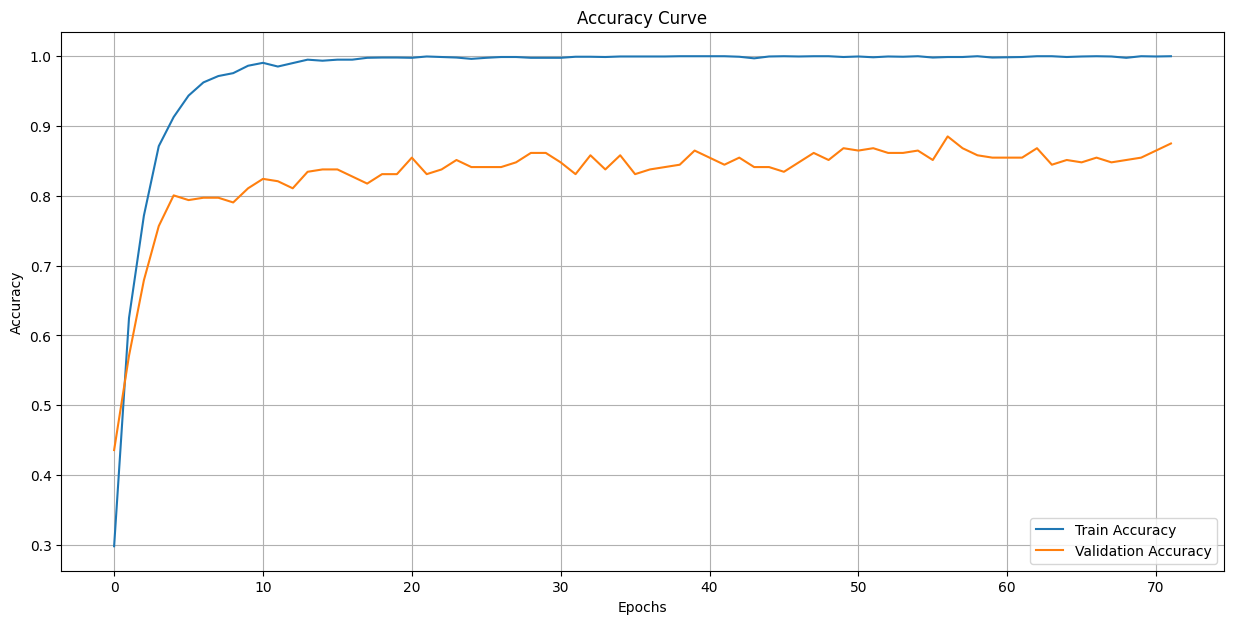

In [ ]:
plot_training(train_losses, val_losses, train_accs, val_accs)

With this new setup we were able to achieve a smoother training process (even if the model is still prone to overfitting, having the great majority of the weights already initialized for the image recognition task) while also reaching a higher value for the best validation accuracy.